In [1]:
#import required packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import re
import numpy as np
from sklearn.metrics import f1_score,classification_report, confusion_matrix,precision_score, recall_score
from tensorflow import keras

In [3]:
#post data
df = pd.read_csv('processed_data/labled_data.csv',usecols=['post', 'prefLabel','obsession'])
df1 = pd.read_csv('input_data/Post_ModelPredictions_ManualChecking.csv', usecols=['post', 'prefLabel'])
df.head()

,post,prefLabel,obsession
0,Hi -\nSo I haven't been on here since December...,"['depression', 'weight gain', 'Medication', 'a...",1
1,"Hi all, hope you're all having a wonderful ban...","['compulsion', 'anger', 'symptom', 'compassion...",1
2,"Hi, \nFirst, I hope everyone managed to have s...","['hope', 'happiness', 'guilt', 'fear', 'obsess...",1
3,Hello everyone. I could really use your help r...,"['Treatment', 'hope', 'Thought', 'obsession', ...",1
4,"Though it comes in many flavors, one of the mo...","['quality', 'Intrusive thoughts', 'fall', 'beh...",1


In [4]:
df1['obsession'] = [0] * len(df1)

In [5]:
df1_emptyLabel = df1[df1['prefLabel'] == '[]']
len(df1_emptyLabel)

2953

In [6]:
df2 = pd.concat([df, df1_emptyLabel], axis=0)

In [7]:
len(df2), df2['obsession'].sum()

(9497, 4985)

In [8]:
df = df2

# **Data Preparation**

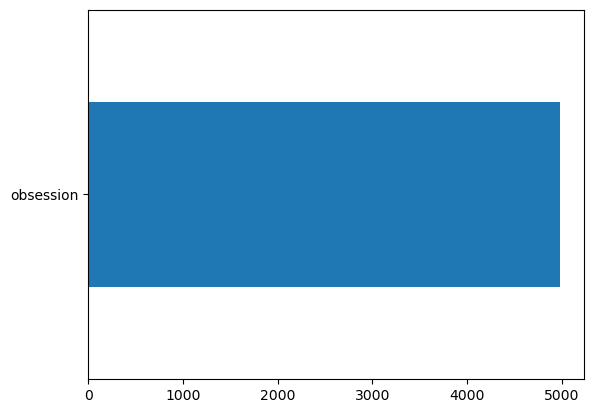

In [9]:
#print the number of post in each ensemble for each class(test data)
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

In [10]:
import re
#define the process of text cleaning
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r' ',text)
#Clean Text
def clean_text(data):
    # convert catacter to lowercase
    data['clean_text']=data['post'].str.lower()
    #remove URLS
    data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r"http\S+", "", elem))
    #remove ponctuation
    data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r"[^\w\s]", "", elem))
    #remove
    data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'/n',"",elem))
    #remove degits
    data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'\d+',"",elem))
    #remove emojis
    data['clean_text'] = data['clean_text'].apply(lambda elem:deEmojify(elem))
    #remove multiple spaces
    data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'\s+'," ",elem))
    #remove single caracter
    data['clean_text'] = data['clean_text'].apply(lambda elem:re.sub(r'\s+[a-zA-Z]\s+'," ",elem))
    return data

In [11]:
#apply the process of cleaning for the train and test data
df = clean_text(df)

In [12]:
#for the text pre-processing (text cleaning)
import nltk
nltk.download('punkt')
import re #regular expression
import string
from nltk.tokenize import word_tokenize # word tokenization
from nltk.stem import PorterStemmer # word stemming

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
def remove_stop_words(text):
  stopW=stopwords.words('english')
  s=""
  for i in text.split():
    if i not in stopW:
        s=s+i+" "
  return s

In [15]:
df['clean_text']=df['clean_text'].apply(lambda x:remove_stop_words(x))

In [16]:
def stem(ch):
  stem = PorterStemmer()
  return " ".join([stem.stem(i) for i in ch.split()])

#apply the stem function to each row in the dataframe
df['clean_text'] = df['clean_text'].apply(lambda x:stem(x))

In [17]:
X, Y = df['clean_text'], df[['obsession']]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

In [18]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7597,), (7597, 1), (1900,), (1900, 1))

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
num_words = 2000
vect=Tokenizer(num_words=num_words)
vect.fit_on_texts(X_train)
vocab_size = len(vect.word_index) + 1
print(vocab_size)

22360


In [25]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
encoded_docs_train = vect.texts_to_sequences(X_train)
MAX_LEN = 150
padded_docs_train = pad_sequences(encoded_docs_train, maxlen=MAX_LEN, padding='pre')
padded_docs_train.shape

(7597, 150)

In [26]:
encoded_docs_test =  vect.texts_to_sequences(X_test)
padded_docs_test = pad_sequences(encoded_docs_test, maxlen=MAX_LEN, padding='pre')

In [27]:
from keras import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout

In [28]:
def get_model():
    model = Sequential()
    # Configuring the parameters
    model.add(Embedding(num_words, output_dim=16, input_length=MAX_LEN))
    model.add(LSTM(16, return_sequences=True))  
    # Adding a dropout layer
    model.add(Dropout(0.5))
    model.add(LSTM(8))
    # model.add(Dropout(0.5))
    model.add(Dense(4))
    # model.add(Dropout(0.5))
    # Adding a dense output layer with sigmoid activation
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())
    return model

In [29]:
obsession_model = get_model()
obsession_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = obsession_model.fit(padded_docs_train, y_train, epochs=1000, batch_size=16,validation_split=0.2,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',patience=20, min_delta=1e-7),
                              keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=10),
                              keras.callbacks.ModelCheckpoint(filepath='model/lstm_obsession_model.h5', 
                                      monitor='val_loss', 
                                      save_best_only=True)])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 16)           32000     
                                                                 
 lstm_2 (LSTM)               (None, 150, 16)           2112      
                                                                 
 dropout_1 (Dropout)         (None, 150, 16)           0         
                                                                 
 lstm_3 (LSTM)               (None, 8)                 800       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 34,953
Trainable params: 34,953
Non-trai

In [30]:
obsession_model.load_weights('model/lstm_obsession_model.h5')
obsession_predictions = obsession_model.predict([padded_docs_test])

60/60 [==============================] - 1s 9ms/step


In [32]:
print('Obsession Prediction Result')
thresholds=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for val in thresholds:
    pred=obsession_predictions.copy()
  
    pred[pred>=val]=1
    pred[pred<val]=0
  
    precision = precision_score(y_test.values, pred, average='micro')
    recall = recall_score(y_test.values, pred, average='micro')
    f1 = f1_score(y_test.values, pred, average='micro')
   
    print("Micro-average quality numbers for threshold", val)
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

Obsession Prediction Result
Micro-average quality numbers for threshold 0.1
Precision: 0.8595, Recall: 0.8595, F1-measure: 0.8595
Micro-average quality numbers for threshold 0.2
Precision: 0.8784, Recall: 0.8784, F1-measure: 0.8784
Micro-average quality numbers for threshold 0.3
Precision: 0.8889, Recall: 0.8889, F1-measure: 0.8889
Micro-average quality numbers for threshold 0.4
Precision: 0.8947, Recall: 0.8947, F1-measure: 0.8947
Micro-average quality numbers for threshold 0.5
Precision: 0.8984, Recall: 0.8984, F1-measure: 0.8984
Micro-average quality numbers for threshold 0.6
Precision: 0.9011, Recall: 0.9011, F1-measure: 0.9011
Micro-average quality numbers for threshold 0.7
Precision: 0.9026, Recall: 0.9026, F1-measure: 0.9026
Micro-average quality numbers for threshold 0.8
Precision: 0.8968, Recall: 0.8968, F1-measure: 0.8968
Micro-average quality numbers for threshold 0.9
Precision: 0.8800, Recall: 0.8800, F1-measure: 0.8800


In [33]:
Y_test = y_test.copy()
Y_test['obsession_pred'] = obsession_predictions

In [34]:
Y_test[:40]

,obsession,obsession_pred
1593,0,0.230116
4313,0,0.005576
2059,1,0.964446
4959,0,0.009660
5299,0,0.076932
4633,0,0.004332
3812,1,0.909074
6098,1,0.931195
3884,1,0.964568
2406,0,0.003659


In [35]:
import pickle
with open('model/lstm_tockenizer_obsession.pkl', 'wb') as f:
    pickle.dump(vect, f)